# Preprocessing

In this notebook I will be taking steps to ensure my data is ready for modeling. I have three ideas I'd like to pursue with regard to modeling so will be looking processing with the idea of creating three datasets. One data set will include only text fields concatted together, the second data set will include all text fields concatted together but combined with the other exogenous variables availble from the other features, and the last data set will be similar to the last but discard the "the advice to management field. The reason for doing this being that the model will be better able to distinguish between positive and negative sentiments if sentiments about future possibilities weren't included.

### Table of Contents 

1. [Step 1: Load Packages](#step1) 
2. [Step 2: Check Target Class for Imbalance](#step2)
3. [Step 3: Preprocessing Categorical and Date Columns](#step3) 
4. [Step 4: Dealing with Rating Columns](#step4) 
5. [Step 5: Handeling the Text Columns](#step5)   
5. [Conclusion](#step6)  
    1. [Next Steps](#section5a) 

<a name="step1"></a>
### Step 1: Load Packages

In [1]:
#import packages
import pandas as pd
import numpy as np 

#Imports for plotting
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

#options
pd.options.display.max_rows = 50
import warnings
warnings.filterwarnings('ignore') 

#NLP Packages
from textblob import TextBlob 
from wordcloud import WordCloud 
import nltk
from nltk.collocations import *
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer 
from nltk.probability import FreqDist
import string
import re


In [2]:
df = pd.read_csv('full_dataset.csv')  
df.head()

,date,employee_title,location,employee_status,review_title,helpful,pros,cons,advice_to_mgmt,rating_overall,rating_balance,rating_culture,rating_career,rating_comp,rating_mgmt,recommends,positive_outlook,approves_of_CEO,company_name
0,Fri Feb 26 2021,Forklift Operator Waerhouse Fabrication,"Atlanta, GA",Current Employee,great,0,always room for improvement. everybody works t...,no cons i love my job\nHelpfu,NaN,5.0,4.0,4.0,4.0,4.0,4.0,Recommends,Positive Outlook,No opinion of CEO,Amazon
1,Sun Jan 10 2016,Anonymous,"Seattle, WA",Current Employee,You Get What You Put In,2685,"Really smart people, a lot of opportunity for ...",You have to be self motivated. NO ONE will hol...,More on-boarding training before new employees...,5.0,4.0,5.0,5.0,5.0,5.0,Recommends,Positive Outlook,Approves of CEO,Amazon
2,Sat Feb 20 2016,Senior Engineering Manager,"Seattle, WA",Current Employee,"Exciting Work, Abusive Culture",2556,"Jeff Bezos and his ""S-Team"" are brilliant and ...","The management process is abusive, and I'm cur...",Don't pretend that the recent NY Times article...,3.0,3.0,3.0,3.0,4.0,4.0,Doesn't Recommend,Positive Outlook,Approves of CEO,Amazon
3,Mon Dec 03 2018,Software Development Manager,"Phoenix, AZ",Current Employee,Amazing company and the most driven and smarte...,758,- You can learn a lot very quickly in a very s...,"- Can be overwhelming, very steep learning cur...",NaN,5.0,3.0,4.0,5.0,5.0,5.0,Recommends,Positive Outlook,Approves of CEO,Amazon
4,Fri Feb 23 2018,Software Development Manager,"Phoenix, AZ",Current Employee,An Amazing Place to Work,786,"I've been at Amazon for a month now, and I've ...","No cons, so far - seriously. Like I said, I'm ...",NaN,5.0,4.0,5.0,5.0,5.0,5.0,Recommends,Positive Outlook,Approves of CEO,Amazon


<a name="step2"></a>
### Step 2: Check Target Class for Imbalance 

Based off the graph below I can tell that some rebalancing will likely be needed. 

Text(0.5, 1.0, 'Distribution of Class')

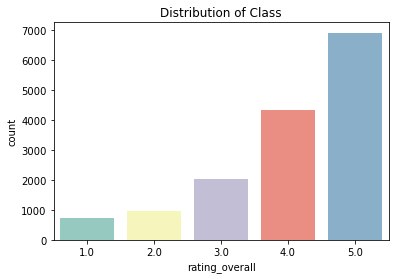

In [3]:
# Checking for class imbalance
sns.countplot(df['rating_overall'], palette='Set3').set_title('Distribution of Class')

In [4]:
def label_function(rating): 
    if rating >= 5: 
        return 'positive' 
    elif rating <= 2: 
        return 'negative' 
    else: 
        return 'neutral' 
    
df['label'] = df['rating_overall'].apply(label_function)

Text(0.5, 1.0, 'Distribution of Class')

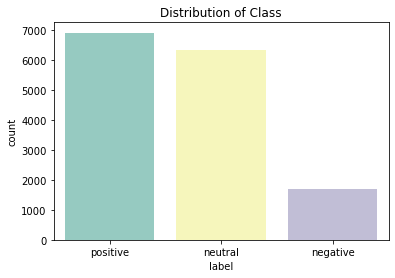

In [5]:
sns.countplot(df['label'], palette='Set3').set_title('Distribution of Class')

<a name="step3"></a>
### Step 3: Preprocessing Categorical and Date Columns

Although this project focuses on sentiment analysis, since I hope to improve my model with exogenous factors I want to do some work to make sure the results are interpretable. I will do this by catagorizing missing values as unknown, since there may be a reason why the user chose not to enter this information, and by simplying some widely varies columns such as employee title into general catagories. 

In [6]:
#Checks for missing values in each column
df.isna().sum()

date                    0
employee_title        122
location             3914
employee_status         0
review_title           62
helpful                 0
pros                  775
cons                    1
advice_to_mgmt      10379
rating_overall          0
rating_balance       3358
rating_culture       3455
rating_career        3500
rating_comp          3544
rating_mgmt          3659
recommends           4450
positive_outlook     5395
approves_of_CEO      5786
company_name            0
label                   0
dtype: int64

In [7]:
#Deal with missing values by making them into an unkown category in some columns
df['employee_title'].fillna('title_unknown', inplace=True) 
df['location'].fillna('unknown,NA', inplace=True) 
df['recommends'].fillna('unknown_recommends', inplace=True) 
df['positive_outlook'].fillna('outlook_unknown', inplace=True) 
df['approves_of_CEO'].fillna('unknown_opinion_of_CEO', inplace=True) 

#### Adressing Date

In [8]:
#Sets date column as a date object
df['date']= pd.to_datetime(df['date'])  #Sets date column as a date object for the purpose of resampling 
df['date'].groupby([df.date.dt.year]).agg('count') #Looks at the counts of reviews by month 

date
2008        8
2009        8
2010       14
2011        9
2012        9
2013       10
2014       39
2015       42
2016       40
2017       56
2018      120
2019      178
2020     2237
2021    12156
Name: date, dtype: int64

#### Adressing Employee Title
Next I adress simplyfying the employee titles. Since we have are looking at various industries, titles are very varied for this reason I am chosing to change this into a binary and focus on whether or not this was information given. 

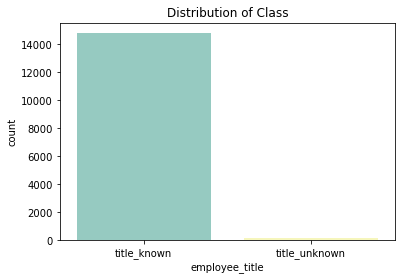

In [9]:
df['employee_title'].loc[df['employee_title'] != 'title_unknown'] = 'title_known' #Replaces all other entries with 'known'

sns.countplot(df['employee_title'], palette='Set3').set_title('Distribution of Class'); #plots distribution


#### Adressing location
For location I decided it would be best to look at region as as generally associated with time zone so I have split the country into 4 regions, as well as catagorized those outside the US and unkown respectively.  

In [10]:
df['area'] = df.location.str[-2:]  #Creates new column using last two characters from location column

#Assigns the last two letters to a region of the US 
df['area'] = df['area'].replace(['CA','NV','OR','WA','AK', 'HI'], 'west_coast')
df['area'] = df['area'].replace(['MT', 'ID', 'WY', 'UT', 'CO', 'AZ', 'NM'], 'mountain')
df['area'] = df['area'].replace(['ND', 'SD', 'NE', 'KS','OK','TX', 'MN', 'IA', 'MO', 'AR', 'LA', 'WI', 'IL', 'MS', 'AL', 'KY', 'TN' ], 'central') 
df['area'] = df['area'].replace(['ME', 'VT', 'NH', 'MA', 'RI', 'CT', 'NY', 'PA', 'NJ', 'DE', 'MD', 'DC', 'VA', 'WV', 'OH', 'MI','IN',
                           'GA', 'SC', 'NC', 'FL', 'PR'], 'east_coast')
df['area'] = df['area'].replace(['AB', 'ON', 'ai', 'GU', 'BC', 'QC', 'lo', 'ng', 'nt', 'VI', 'ār', 'nd', 'on', 'st', 're', 'ad','da',
                           'ar', 'er', 'ya'], 'outside_US') 
#Replaces NA value with Unknown 
df['area'] = df['area'].replace(['NA'],'unknown')

del df['location'] #Drops the old location column

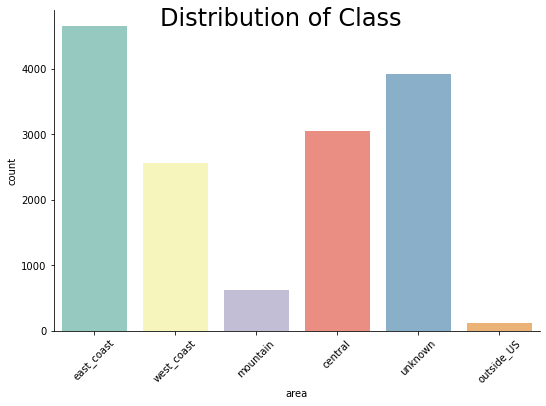

In [11]:
#plots distribution of Area column
g = sns.factorplot("area", data=df, aspect=1.5, kind="count", palette='Set3')
g.set_xticklabels(rotation=45) 
g.fig.suptitle("Distribution of Class", fontsize=24);

#### Adressing Employee Status

This column is largely filled so here I rename the main two catagories for the sake of consistency and catagorize the rest as unkown. 

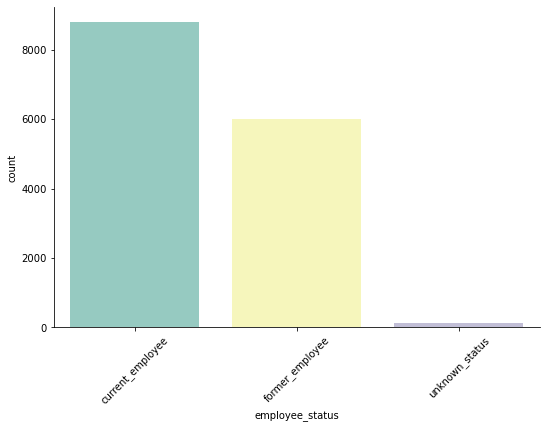

In [12]:
df['employee_status'] = df['employee_status'].replace(['Current Employee ', 'Former Employee '],['current_employee','former_employee'])
df['employee_status'] = df['employee_status'].replace(['Site Selection Program Manager in Menlo Park, CA',' in Fairfax, VA', ' in Baltimore, MD', ' ', ' in Timonium, MD',
       ' in Washington, DC', 'Attorney ', ' in Century City, CA','Attorney in Columbia, MD', 'Legal Secretary in Century City, CA',
       'Employee in Washington, DC', ' in Memphis, TN', 'Co', 'Scientific Technical Writer/Media Planner in Memphis, TN','Sales Representative in Green Bay, WI',
       'Technical Representative in Trois', 'Area Representative ','Associate Software Engineer in Bellevue, WA','Senior Marketing Research Manager in Bellevue, WA',
        ' in Bellevue, WA','Director of Business Development in Bellevue, WA','Test Manager in Bellevue, WA','Service Desk Representative in Bellevue, WA',
       'Software Engineer in Bellevue, WA','Cloud Software Engineer in Bothell, WA', 'Software Engineer ','Senior Software Engineer ', 'Delivery Driver in Auburn, ME',
       'Store Manager in Orlando, FL', 'GM Manager ', 'Clinical Project Manager in Blue Bell, PA', ' in Inglewood, CA','Senior Executive Administrator/Associate in Denver, CO',
       'Phone Agent in Chicago, IL','Customer Experience Specialist in Aurora, IL', ' in Chicago, IL','Dyson Expert in Portland, OR','Customer Service Agent in Remote, OR',
       'Computer Programmer in Brooklyn, NY','Project Manager in Cincinnati, OH','Project Manager in New York, NY', ' in Portland, OR','Project Coordinator in Bloomington, IL',
       'Advertising in Los Angeles, CA','Project Manager in San Jose, CA','Senior Software Engineer in Atlanta, GA', ' in Cambridge, MA','Software Specialist in Cincinnati, OH',
       'Project Manager in Holtsville, NY','Software Specialist in Baltimore, MD','IT Project Manager in Marlborough, MA','Telecom Business Analyst in Farmington, MN',
       'Software Engineer in Boston, MA','Project Manager in Bloomington, IL','Senior Software Engineer in Chicago, IL','Business Analyst in Jersey City, NJ',
       'Team Lead in Bloomington, IL','Senior Software Engineer in Bloomington, IL','Software Specialist in California City, CA', 'Software Specialist in Baldwin Park, CA', ' in Tampa, FL',
       'Network Support Engineer in Bridgeport, CT','Solution Architect in Milpitas, CA', 'Director in Boston, MA','Assistant Vice President in Washington, DC',
       ' in Saint Louis, MO','Meat Eater Tester Manager in American Fork, UT',' in Atlanta, GA'], 'unknown_status')  #Replaces all other entries with 'unknown'

df['employee_status'].value_counts() 


g = sns.factorplot("employee_status", data=df, aspect=1.5, kind="count", palette='Set3')
g.set_xticklabels(rotation=45);

#### Adressing Helpful

Since most reviews are unrated in this category, I will be turning this into a binary to be used during feature engineering at a later point.

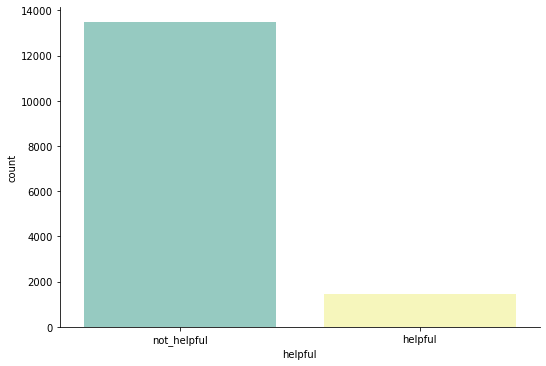

In [13]:
df['helpful'].loc[df['helpful'] != 0] = 1 
df['helpful'] = df['helpful'].replace([0, 1], ['not_helpful','helpful']) 

df.helpful.value_counts() 

g = sns.factorplot("helpful", data=df, aspect=1.5, kind="count", palette='Set3');

#### Adressing Recommends

This column has been negatively affected by Glassdoor recent change in system and as result has entries that do not fit this column, they will be catagorized into unknown. 

In [14]:
#Replaces names for consistency
df['recommends'] = df['recommends'].replace(['Recommends', "Doesn't Recommend"],['recommends','does_not_recommend'])
#Recatagorizes into unknown class
df['recommends'] = df['recommends'].replace(['Approves of CEO', 'Positive Outlook', 'No opinion of CEO', 'Neutral Outlook', 
                                             'Disapproves of CEO', 'Negative Outlook'], 'unknown_recommends') 


df.recommends.value_counts() 

recommends            7817
unknown_recommends    4746
does_not_recommend    2363
Name: recommends, dtype: int64

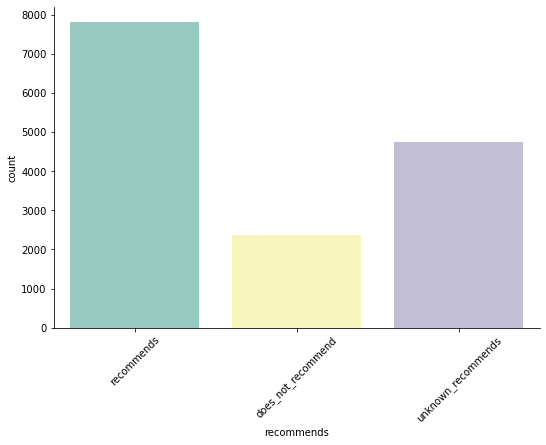

In [15]:
g = sns.factorplot("recommends", data=df, aspect=1.5, kind="count", palette='Set3')
g.set_xticklabels(rotation=45);

#### Adressing Positive_outlook and Approves_of_CEO

These two columns only need to be renamed to match the rest of the data so I will clean them together.

In [16]:
#Renames values in positive outlook column
df['company_outlook'] = df['positive_outlook'].replace(['Positive Outlook', "Neutral Outlook", "Negative Outlook"],
                                                       ['positive_outlook','neutral_outlook', 'negative_outlook']) 

del df['positive_outlook'] #Drops the old  column 

#Renames values in positive outlook column
df['opinion_of_CEO'] = df['approves_of_CEO'].replace(['Approves of CEO', "No opinion of CEO", "Disapproves of CEO"],
                                                       ['approves_of_CEO','no_opinion_of_CEO', 'disapproves_of_CEO']) 

del df['approves_of_CEO'] #Drops the old  column 

In [17]:
df['company_outlook'].value_counts()

positive_outlook    6383
outlook_unknown     5395
neutral_outlook     1945
negative_outlook    1203
Name: company_outlook, dtype: int64

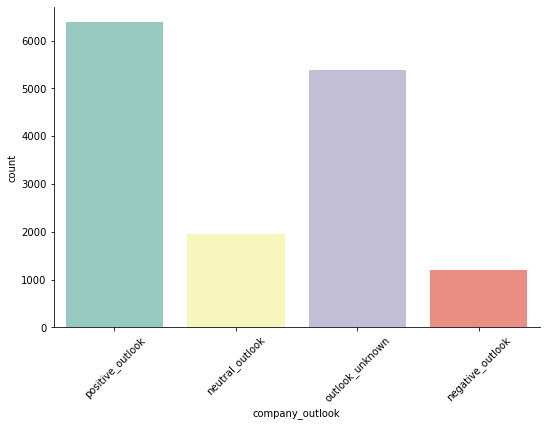

In [18]:
#Plots outlook
g = sns.factorplot("company_outlook", data=df, aspect=1.5, kind="count", palette='Set3')
g.set_xticklabels(rotation=45);

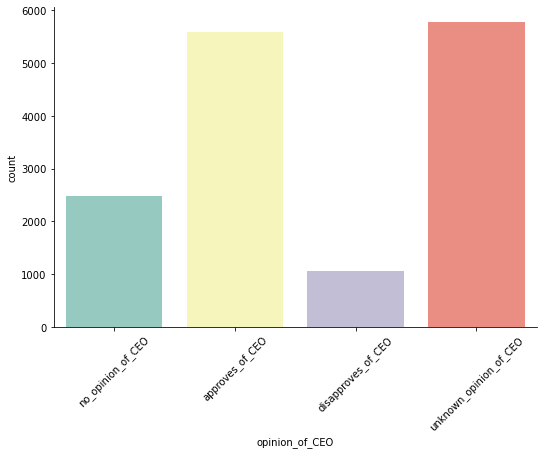

In [19]:
#Plot opnion of CEO
g = sns.factorplot("opinion_of_CEO", data=df, aspect=1.5, kind="count", palette='Set3')
g.set_xticklabels(rotation=45);

In [20]:
df.head()

,date,employee_title,employee_status,review_title,helpful,pros,cons,advice_to_mgmt,rating_overall,rating_balance,rating_culture,rating_career,rating_comp,rating_mgmt,recommends,company_name,label,area,company_outlook,opinion_of_CEO
0,2021-02-26,title_known,current_employee,great,not_helpful,always room for improvement. everybody works t...,no cons i love my job\nHelpfu,NaN,5.0,4.0,4.0,4.0,4.0,4.0,recommends,Amazon,positive,east_coast,positive_outlook,no_opinion_of_CEO
1,2016-01-10,title_known,current_employee,You Get What You Put In,helpful,"Really smart people, a lot of opportunity for ...",You have to be self motivated. NO ONE will hol...,More on-boarding training before new employees...,5.0,4.0,5.0,5.0,5.0,5.0,recommends,Amazon,positive,west_coast,positive_outlook,approves_of_CEO
2,2016-02-20,title_known,current_employee,"Exciting Work, Abusive Culture",helpful,"Jeff Bezos and his ""S-Team"" are brilliant and ...","The management process is abusive, and I'm cur...",Don't pretend that the recent NY Times article...,3.0,3.0,3.0,3.0,4.0,4.0,does_not_recommend,Amazon,neutral,west_coast,positive_outlook,approves_of_CEO
3,2018-12-03,title_known,current_employee,Amazing company and the most driven and smarte...,helpful,- You can learn a lot very quickly in a very s...,"- Can be overwhelming, very steep learning cur...",NaN,5.0,3.0,4.0,5.0,5.0,5.0,recommends,Amazon,positive,mountain,positive_outlook,approves_of_CEO
4,2018-02-23,title_known,current_employee,An Amazing Place to Work,helpful,"I've been at Amazon for a month now, and I've ...","No cons, so far - seriously. Like I said, I'm ...",NaN,5.0,4.0,5.0,5.0,5.0,5.0,recommends,Amazon,positive,mountain,positive_outlook,approves_of_CEO


<a name="step4"></a>
### Step 4: Deal w/ Missing Continuous Values  

While my target is not missing any values the other rating columns do contain missing values. For the purpose of the project I will assign thos missing values a zero since although they are numerical, they should be thought of as categorical. 

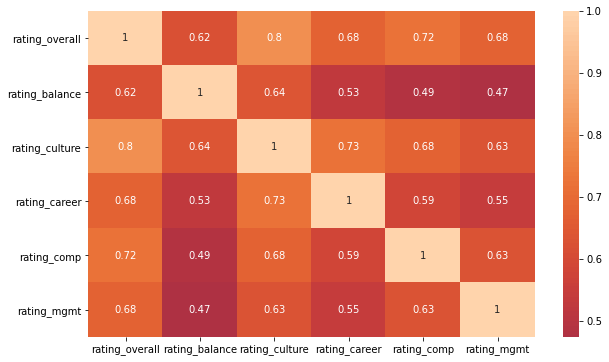

In [21]:
# Looking for any hidden correlations between continuous variables

fig, ax = plt.subplots(figsize=(10, 6))

corr = df.corr()

sns.heatmap(corr, center=0, annot=True)

plt.show()

In [22]:
#Fill in missing values
df['rating_balance'].fillna(0, inplace=True)  
df['rating_culture'].fillna(0, inplace=True) 
df['rating_career'].fillna(0, inplace=True) 
df['rating_comp'].fillna(0, inplace=True) 
df['rating_mgmt'].fillna(0, inplace=True) 

In [23]:
df.isna().sum()

date                   0
employee_title         0
employee_status        0
review_title          62
helpful                0
pros                 775
cons                   1
advice_to_mgmt     10379
rating_overall         0
rating_balance         0
rating_culture         0
rating_career          0
rating_comp            0
rating_mgmt            0
recommends             0
company_name           0
label                  0
area                   0
company_outlook        0
opinion_of_CEO         0
dtype: int64

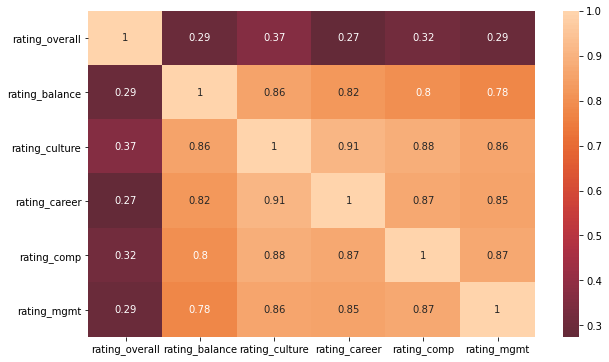

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))

corr = df.corr()

sns.heatmap(corr, center=0, annot=True)

plt.show()

<a name="step5"></a>
### Step 5: Transforming the Text Columns for NLP

Now that all other columns has been cleaned and transformed, I am ready to address the text columns. In this section, I will perform cleanup, lemming, and vectorization.  

#### Basic column clean up 

In [25]:
#Confirms all text columns are strings
df['review_title'] = df['review_title'].astype(str) 
df['pros'] = df['pros'].astype(str) 
df['cons'] = df['cons'].astype(str) 
df['advice_to_mgmt'] = df['advice_to_mgmt'].astype(str) 

#Concats the four columns of text into single columns
df["review_text"] = df["review_title"] + " " + df["pros"] + " " + df["cons"] + " " + df["advice_to_mgmt"] 

#Drops the four initial text columns now that the text has been moved
df.drop(['review_title', 'pros', 'cons','advice_to_mgmt'], axis=1, inplace=True)  

#Having seen a few /n  in the text, running this line to remove any that were missed during the scrape 
df = df.replace('\n',' ', regex=True) 

In [28]:
#Tokenize Text 

def token(review_text): 
    return word_tokenize(review_text) 

df["review_text"] = df["review_text"].apply(token)  

In [33]:
df1["review_text"].value_counts()

Great company ! I started at this comany with out any experince and they trained me all the way . Now as a Field Service Manager i have lots of hours and lots of experince that Im sharing with my current team , DISH has made it really easy to grow inside the company . Long days 12-14 hour shifts Helpfu nan                                                                                                                                                                                      6
Okay to work for just busy Move into other positions quickly as long as you follow your coaching . Good benefits and split shifts Busy call volume with a lot of angry customers calling . Not enough PTO Helpfu nan                                                                                                                                                                                                                                                                                     6
I love my job at D

#### Remove uneeded characters and format 

In [26]:
#Remove numbers
df['review_text'] = df['review_text'].str.replace('\d+', '')

#Remove all non alpha numberica characters 
df['review_text'] = df['review_text'].str.replace(r'[^\w\s]+', '') 

#Converts all words to lowercase 
df["review_text"] = df["review_text"].str.lower() 

#Converts all words to lowercase 
df["review_text"] = df["review_text"].str.lower()

#### Tokenize and Remove Stop Words 

In [28]:
#Removing Stopwords
stop_words = set(stopwords.words('english'))
df["review_text"] = df["review_text"].apply(lambda x: [word for word in x if word not in stop_words])

#Remove additional stop words
add_words = ['work', 'nan', 'get']
df["review_text"] = df["review_text"].apply(lambda x: [word for word in x if word not in add_words])
 


#### Lemmatization

In [29]:
#Lemmatize
lemma = WordNetLemmatizer() 

def clean_lemma(text):
    return [lemma.lemmatize(word=w, pos='v') for w in text] 

df["review_text"] = df["review_text"].apply(clean_lemma) 

#Remove "words" less than two characters in length 
def clean_length(text): 
    return [i for i in text if len(i) > 2] 

df["review_text"] = df["review_text"].apply(clean_length)  

#Fix the word helpfu
df["review_text"] = df["review_text"].replace('helpfu', 'helpful')


In [32]:
df1 = df.copy()

#Convert list of strings back to string 

def convert_string(text): 
    return ' '.join(text) 

df1["review_text"] = df1["review_text"].apply(convert_string) 

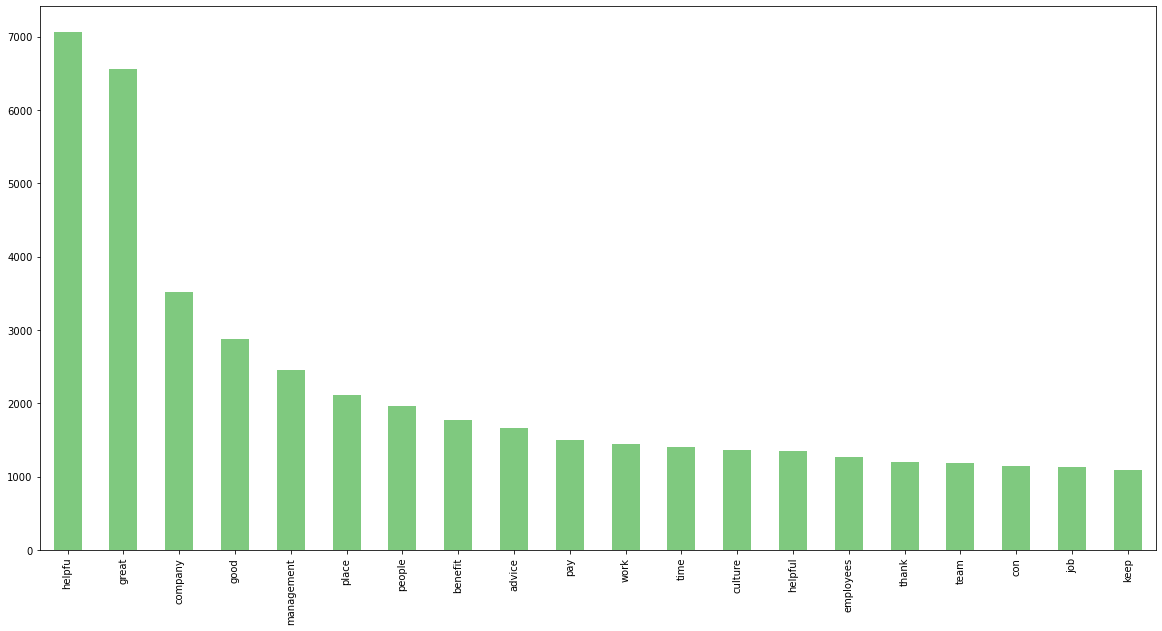

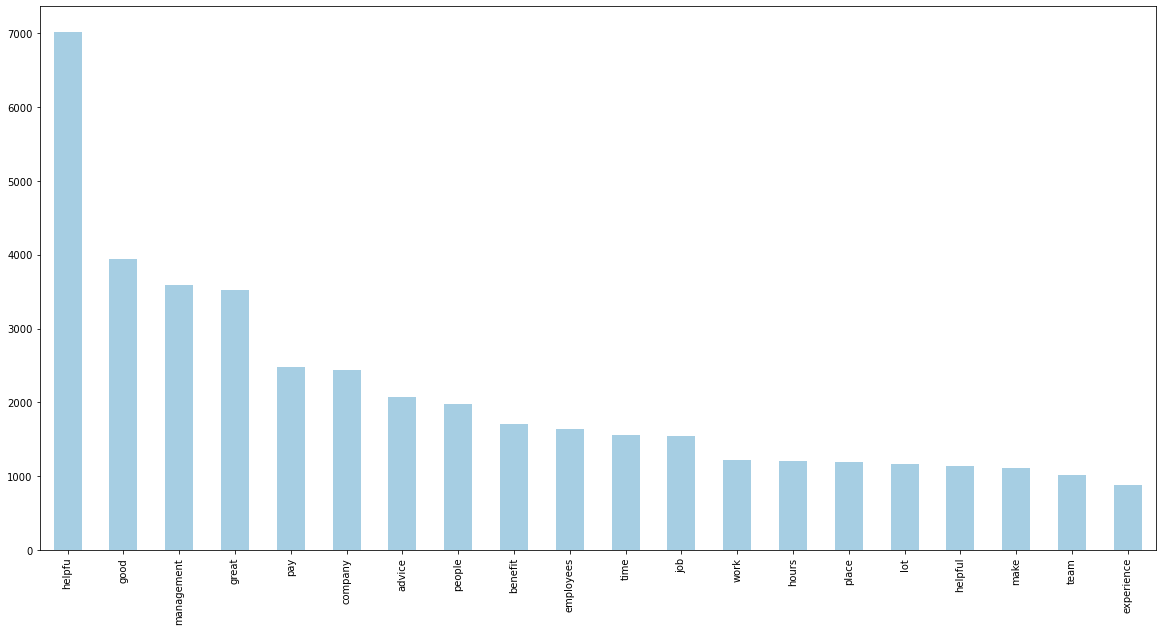

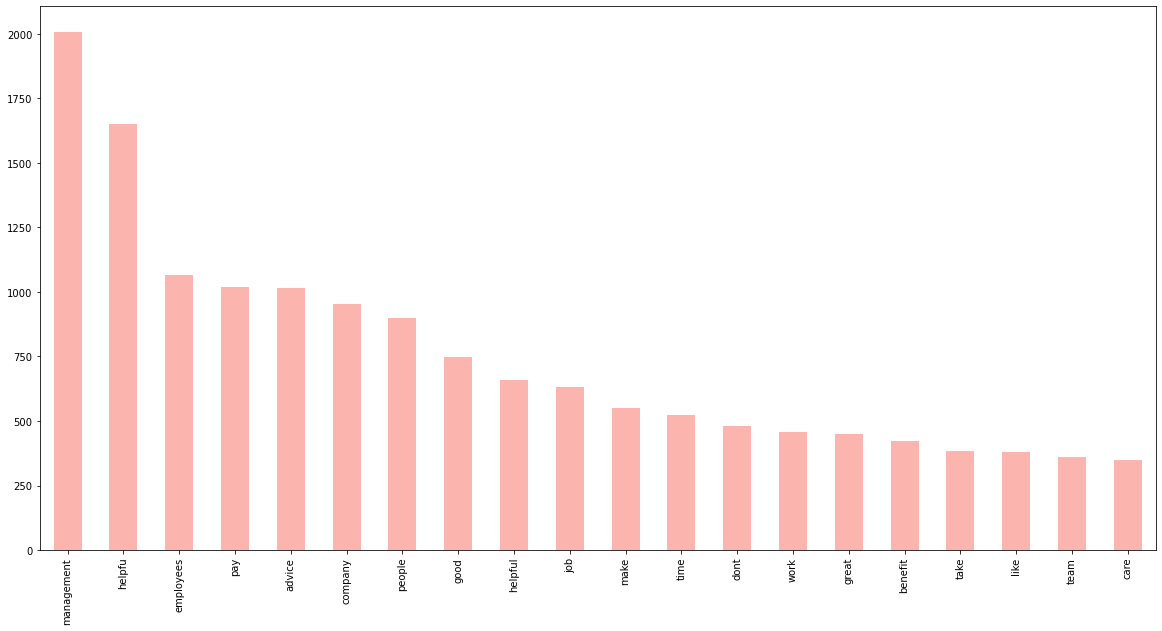

In [31]:
PositiveReview = df1[df1.label == 'positive']['review_text']
NeutralReview = df1[df1.label == 'neutral']['review_text']
NegativeReview = df1[df1.label == 'negative']['review_text']

color = ['Accent', 'Paired', 'Pastel1'] 
splitdata = [PositiveReview, NeutralReview, NegativeReview] 

for item in range(3): 
    plt.figure(figsize=(20,10))
    pd.Series(' '.join([i for i in splitdata[item]]).split()).value_counts().head(20).plot(kind='bar', colormap=color[item])